In [1]:
import pandas as pd
import numpy as np
from KRData.HKData import *
from ib_insync import *
import datetime as dt
from IPython.display import display, clear_output

In [8]:
hf = HKFuture('krdata', 'kairuitouzi')

In [9]:
data = hf.get_main_contract_bars('HSI', start='20181201') # 获取需要对照的历史K线

In [10]:
util.startLoop()
ib = IB()
ib.connect(clientId=9)
hsi1904 = Future('HSI', '201904')
ib.qualifyContracts(hsi1904)

API connection failed: ConnectionRefusedError(10061, "Connect call failed ('127.0.0.1', 7497)")
Make sure API port on TWS/IBG is open


ConnectionRefusedError: [Errno 10061] Connect call failed ('127.0.0.1', 7497)

In [5]:
mkData = ib.reqHistoricalData(hsi1904, '', f'{60*100} S', '1 min', 'TRADES', useRTH=False, keepUpToDate=True)

NameError: name 'hsi1904' is not defined

In [6]:
def analyze(targetData: pd.DataFrame, sourceData: pd.DataFrame, corrThreshold=0.8):
    targetSize = len(targetData)
    sourceSize = len(sourceData)
    ret = []
    for i in range(sourceSize-targetSize):
        sc = sourceData[i:i+targetSize]
        corr=np.corrcoef(targetData, sc)[0][1]
        ret.append([sc.index[0], sc.index[-1], corr])
    
    gt_threshold = [r for r in ret if r[-1]>corrThreshold]
    
    # 过滤连续K线高相关
    filtedRet = []
    if len(gt_threshold)>=2:
        r=gt_threshold[0]
        for i in range(len(gt_threshold)-1):
            if (gt_threshold[i+1][1] -gt_threshold[i][0])*0.9<=(gt_threshold[i][1] -gt_threshold[i+1][0]):
                r =gt_threshold[i+1] if gt_threshold[i+1][-1]>r[-1] else r
            else:
                filtedRet.append(r)
                r=gt_threshold[i+1]
        else:
            filtedRet.append(r)
    else:
        filtedRet = gt_threshold
        
    return filtedRet

In [7]:
def analyzeHistoricalData(bars, hasNewBar):
    if hasNewBar:
        targetData = util.df(bars[-100:]).rename(columns={'date':'datetime'})
        print('NewBarComing...Calculating!!!')
        result = analyze(targetData.close, data.close, 0.6)
        if len(result) !=0:
            clear_output()
            print(f'Get {len(result)} match!!!')
            result.sort(key=lambda x: x[-1], reverse=True)
            top1 = result[0]
            print( f'Top1 Corr:{top1[-1]}')
            fig = hf.draw_klines(data[top1[0]:top1[1]])
            display(fig)
        else:
            print("Get No match")

In [8]:
mkData.updateEvent += analyzeHistoricalData

Get 237 match!!!
Top1 Corr:0.9041778829381246


Get 253 match!!!
Top1 Corr:0.9119517273415865


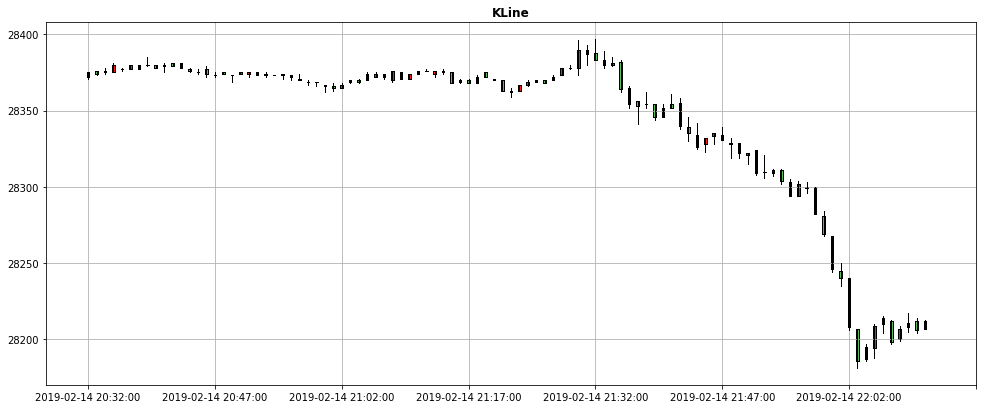

In [10]:
%pylab inline